In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import PIL
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall, AUC
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path="/content/drive/MyDrive/Colab Notebooks/mydataset"
train_path='/content/drive/MyDrive/Colab Notebooks/mydataset/train'
test_path='/content/drive/MyDrive/Colab Notebooks/mydataset/test'

In [ ]:
IMAGE_SIZE = 200
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10


 IMPORTING IMAGES
 

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                 image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True
                                                 )




Found 5232 files belonging to 3 classes.


In [ ]:
len(dataset)

164

In [ ]:
 for image_batch, label_batch in dataset.take(1):
   print(image_batch[0].shape)

(200, 200, 3)


In [ ]:
class_names= dataset.class_names
class_names

['BACTERIAL PNEUMONIA', 'NORMAL', 'VIRAL PNEUMONIA']

In [ ]:
len(train_path)

54

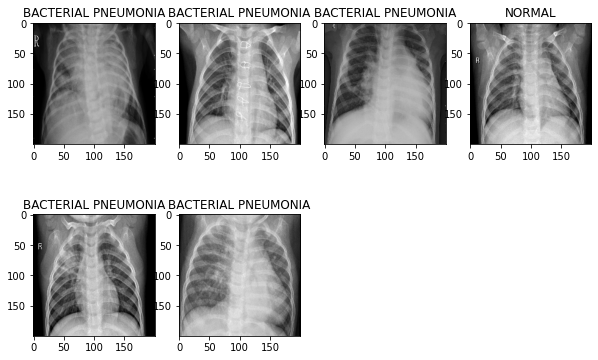

In [ ]:
 plt.figure(figsize=(10,10))
 for image_batch, label_batch in dataset.take(1):
   for i in range(6):
     ax = plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]])

In [ ]:
train_size = 0.8
len(dataset)*train_size

131.20000000000002

In [ ]:
train_ds = dataset.take(131)
len(train_ds)

131

In [ ]:
test_ds = dataset.skip(131)
len(test_ds)

33

In [ ]:
val_size=0.1
len(dataset)*val_size

16.400000000000002

In [ ]:
val_ds = test_ds.take(16)
len(val_ds)

16

In [ ]:
test_ds = test_ds.skip(16)
len(test_ds)

17

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
                                          layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                                          layers.experimental.preprocessing.Rescaling(1.0/255)

])


In [ ]:
data_augmentation= tf.keras.Sequential([
                                        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                        layers.experimental.preprocessing.RandomRotation(10),
                                        tf.keras.layers.RandomZoom(0.2),

                                        ])

In [ ]:
resnet = ResNet50(input_shape=(200, 200, 3), weights='imagenet', include_top=False)

In [ ]:
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(len(class_names), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
metrics = [
    tf.keras.metrics.SparseCategoricalCrossentropy(
        name='sparse_categorical_crossentropy'),
    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision', top_k=1),
    tf.keras.metrics.Precision(name='precision', top_k=3),
    tf.keras.metrics.Recall(name='recall', top_k=1),
    tf.keras.metrics.Recall(name='recall', top_k=3),
]

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics= ['accuracy']
)

In [ ]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs= 10)


Epoch 1/10
131/131 [==============================] - 79s 365ms/step - loss: 4.6641 - accuracy: 0.7289 - val_loss: 3.6315 - val_accuracy: 0.7441
Epoch 2/10
131/131 [==============================] - 14s 106ms/step - loss: 1.8614 - accuracy: 0.8532 - val_loss: 1.1673 - val_accuracy: 0.8789
Epoch 3/10
131/131 [==============================] - 13s 102ms/step - loss: 1.5783 - accuracy: 0.8872 - val_loss: 1.3284 - val_accuracy: 0.8945
Epoch 4/10
131/131 [==============================] - 13s 102ms/step - loss: 0.9065 - accuracy: 0.9239 - val_loss: 0.9732 - val_accuracy: 0.9375
Epoch 5/10
131/131 [==============================] - 13s 100ms/step - loss: 0.3799 - accuracy: 0.9593 - val_loss: 0.7541 - val_accuracy: 0.9531
Epoch 6/10
131/131 [==============================] - 13s 101ms/step - loss: 0.4093 - accuracy: 0.9562 - val_loss: 0.7698 - val_accuracy: 0.9453
Epoch 7/10
131/131 [==============================] - 13s 103ms/step - loss: 0.2600 - accuracy: 0.9674 - val_loss: 0.9860 - val_ac

In [ ]:
scores= model.evaluate(test_ds)

17/17 [==============================] - 39s 96ms/step - loss: 1.0751 - accuracy: 0.9375


In [ ]:
scores

[1.0750669240951538, 0.9375]

In [ ]:
history

In [ ]:
history.params


{'epochs': 10, 'steps': 131, 'verbose': 1}

In [ ]:
history.history['accuracy']


[0.7289271950721741,
 0.8532088398933411,
 0.8872126340866089,
 0.9238505959510803,
 0.9592911601066589,
 0.9561781883239746,
 0.967432975769043,
 0.9832375645637512,
 0.9863505959510803,
 0.9875478744506836]

In [ ]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

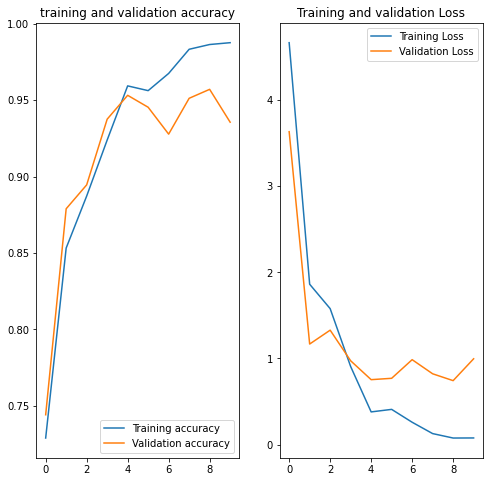

In [ ]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title("training and validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc='upper right')
plt.show()


first image to predict
actual label: VIRAL PNEUMONIA
predicted label: VIRAL PNEUMONIA


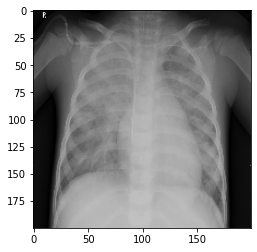

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    

In [ ]:
labels_batch[1].numpy()

0

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


In [ ]:
new = [np.argmax(batch_prediction[i])for i in labels_batch]


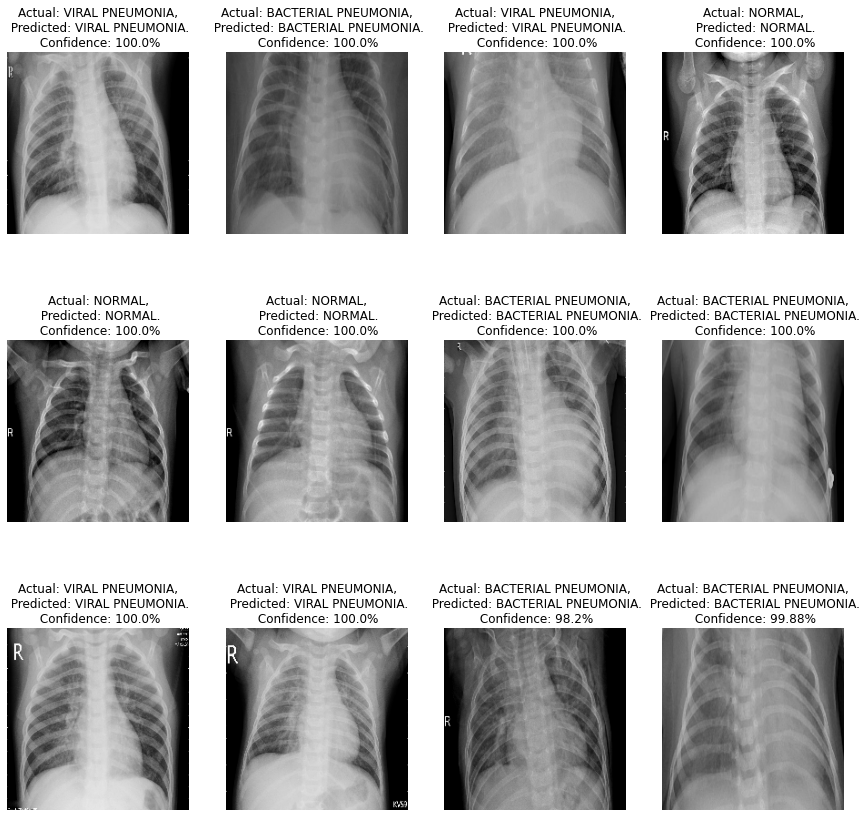

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
cmlabel= [labels_batch[i].numpy() for i in labels_batch]





In [ ]:
cm = tf.math.confusion_matrix(labels=cmlabel , predictions=new)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 6,  0,  0],
       [ 0,  0,  0],
       [ 0,  0, 26]], dtype=int32)>

Text(69.0, 0.5, 'Truth')

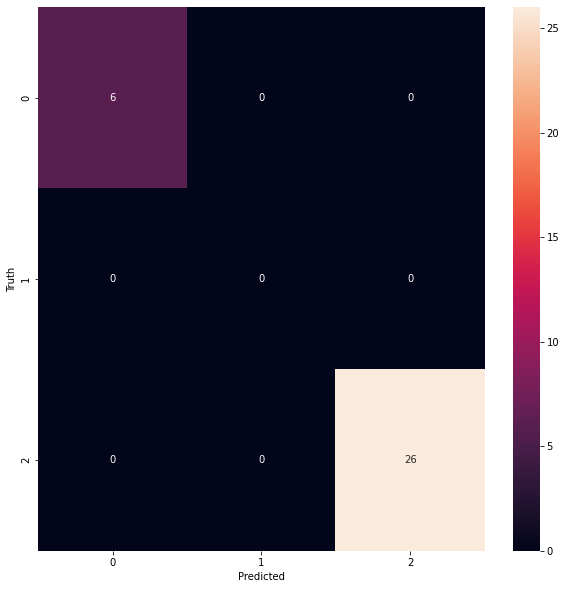

In [ ]:
import seaborn as sn
plt.figure(figsize = (10,10))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd